In [1]:
## for data
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for statistical tests
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm
## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition

In [2]:
df = pd.read_csv('/content/primary_data.csv', on_bad_lines='skip',sep = ';')

In [3]:
df = df.drop(columns=['gill-spacing','stem-root','stem-surface','veil-type','veil-color','Spore-print-color'])
df['Cap-surface'] = df['Cap-surface'].fillna('[n]')
df['gill-attachment'] = df['gill-attachment'].fillna('[n]')
df['ring-type'] = df['ring-type'].fillna('[n]')

df['season-spring'] = df['season'].apply(lambda x: 's' in x)
df['season-summer'] = df['season'].apply(lambda x: 'u' in x)
df['season-autumn'] = df['season'].apply(lambda x: 'a' in x)
df['season-winter'] = df['season'].apply(lambda x: 'w' in x)
df = df.drop(columns=['season'])
df['season-spring'] = df['season-spring'].astype(int)
df['season-summer'] = df['season-summer'].astype(int)
df['season-autumn'] = df['season-autumn'].astype(int)
df['season-winter'] = df['season-winter'].astype(int)

from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
df[['family','class','cap-shape','Cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-color', 'stem-color','has-ring','ring-type','habitat']] = enc.fit_transform(df[['family','class','cap-shape','Cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-color', 'stem-color','has-ring','ring-type','habitat']])

df[['cap-diameter-min', 'cap-diameter-max']] = df['cap-diameter'].str.extract(r'\[([\d.]+)(?:,\s*([\d.]+))?\]')
df['cap-diameter-min'] = pd.to_numeric(df['cap-diameter-min'])
df['cap-diameter-max'] = pd.to_numeric(df['cap-diameter-max']).fillna(df['cap-diameter-min'])
df = df.drop(columns=['cap-diameter'])

df[['stem-height-min', 'stem-height-max']] = df['stem-height'].str.extract(r'\[([\d.]+)(?:,\s*([\d.]+))?\]')
df['stem-height-min'] = pd.to_numeric(df['stem-height-min'])
df['stem-height-max'] = pd.to_numeric(df['stem-height-max']).fillna(df['stem-height-min'])
df = df.drop(columns=['stem-height'])

df[['stem-width-min', 'stem-width-max']] = df['stem-width'].str.extract(r'\[([\d.]+)(?:,\s*([\d.]+))?\]')
df['stem-width-min'] = pd.to_numeric(df['stem-width-min'])
df['stem-width-max'] = pd.to_numeric(df['stem-width-max']).fillna(df['stem-width-min'])
df = df.drop(columns=['stem-width'])

df = df.drop(columns=['name'])

In [4]:
def utils_recognize_type(dtf, col, max_cat=20):
    if (dtf[col].dtype == "O") | (dtf[col].nunique() < max_cat):
        return "cat"
    else:
        return "num"

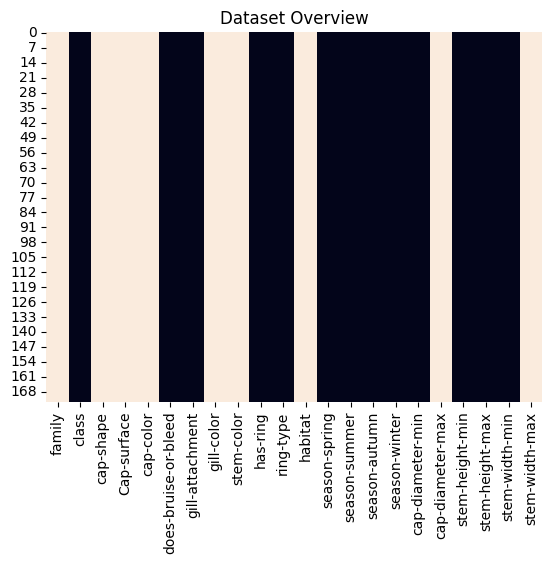

 Categerocial   Numeric   NaN 


In [5]:
dic_cols = {col:utils_recognize_type(df, col, max_cat=20) for col in df.columns}

heatmap = df.isnull()

for k,v in dic_cols.items():
    if v == "num":
        heatmap[k] = heatmap[k].apply(lambda x: 0.5 if x is False else 1)
    else:
        heatmap[k] = heatmap[k].apply(lambda x: 0 if x is False else 1)

sns.heatmap(heatmap, cbar=False).set_title('Dataset Overview')

plt.show()
print("\033[1;37;40m Categerocial ", "\033[1;30;41m Numeric ", "\033[1;30;47m NaN ")

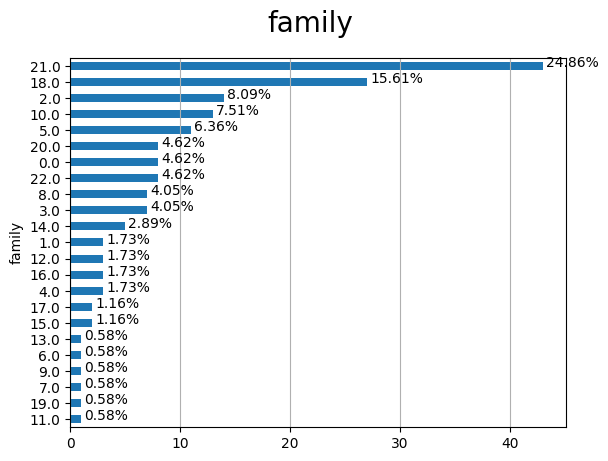

In [6]:
y = "family"

ax = df[y].value_counts().sort_values().plot(kind="barh")

totals= []
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)
for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+.20,
            str(round((i.get_width()/total)*100, 2))+'%',
            fontsize=10, color='black')
ax.grid(axis="x")
plt.suptitle(y, fontsize=20)

plt.show()

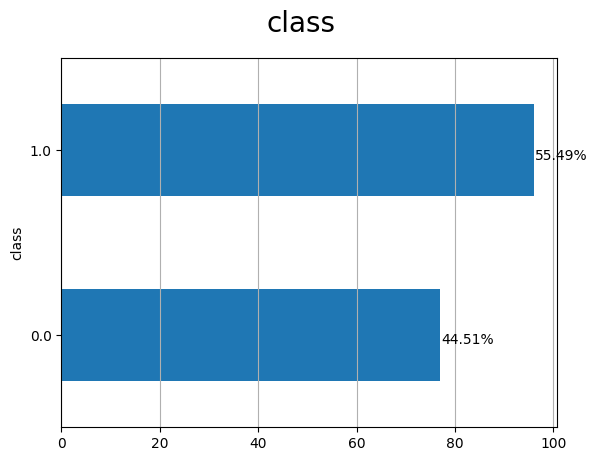

In [7]:
y = "class"

ax = df[y].value_counts().sort_values().plot(kind="barh")

totals= []
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)
for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+.20,
            str(round((i.get_width()/total)*100, 2))+'%',
            fontsize=10, color='black')
ax.grid(axis="x")
plt.suptitle(y, fontsize=20)

plt.show()

In [8]:
cat_columns = df.select_dtypes(['object']).columns
df[cat_columns] = df[cat_columns].apply ( lambda x: pd.factorize (x)[ 0 ])
#df = df / df.abs().max()

In [9]:
def show_dist(x, dtf):
    fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(15, 10))
    fig.suptitle(x, fontsize=20)
    ### distribution
    ax[0].title.set_text('distribution')
    variable = dtf[x].fillna(dtf[x].mean())
    breaks = np.quantile(variable, q=np.linspace(0, 1, 11))
    variable = variable[(variable > breaks[0]) & (variable <
                                                  breaks[10])]
    sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True},
                 ax=ax[0])  #Запишем чтобы создать горизонтальную гистограмму
    des = dtf[x].describe()
    ax[0].axvline(des["25%"], ls='--')
    ax[0].axvline(des["mean"], ls='--')
    ax[0].axvline(des["75%"], ls='--')
    ax[0].grid(True)
    des = round(des, 2).apply(lambda x: str(x))
    box = '\n'.join(
        ("min: " + des["min"], "25%: " + des["25%"], "mean: " + des["mean"], "75%: " + des["75%"], "max: " + des["max"]))
    ax[0].text(0.95, 0.95, box, transform=ax[0].transAxes, fontsize=10, va='top', ha="right",
               bbox=dict(boxstyle='round', facecolor='white', alpha=1))
    ax[1].title.set_text('outliers (log scale)')
    tmp_dtf = pd.DataFrame(dtf[x])
    tmp_dtf[x] = np.log(tmp_dtf[x])
    tmp_dtf.boxplot(column=x, ax=ax[1])

    plt.show()

<ipython-input-9-8d5c53b7a6e9>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True},
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2496: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


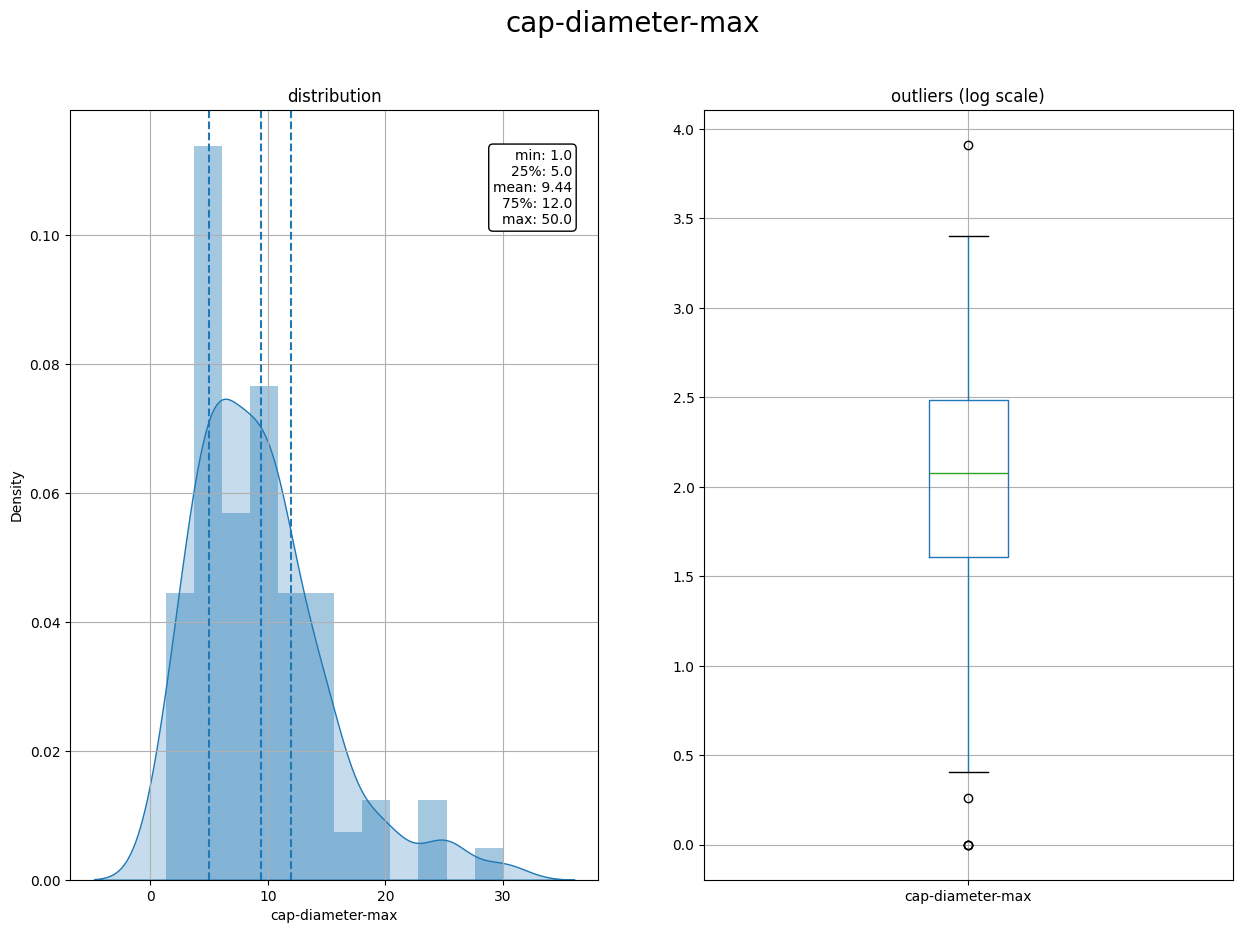

In [10]:
show_dist("cap-diameter-max", df)

Основная масса данных сосредоточена в пределах среднего диапазона (от 5 до 12), но присутствуют несколько экстремальных значений, которые могут повлиять на дальнейший анализ.

<ipython-input-16-8d5c53b7a6e9>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True},
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2496: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


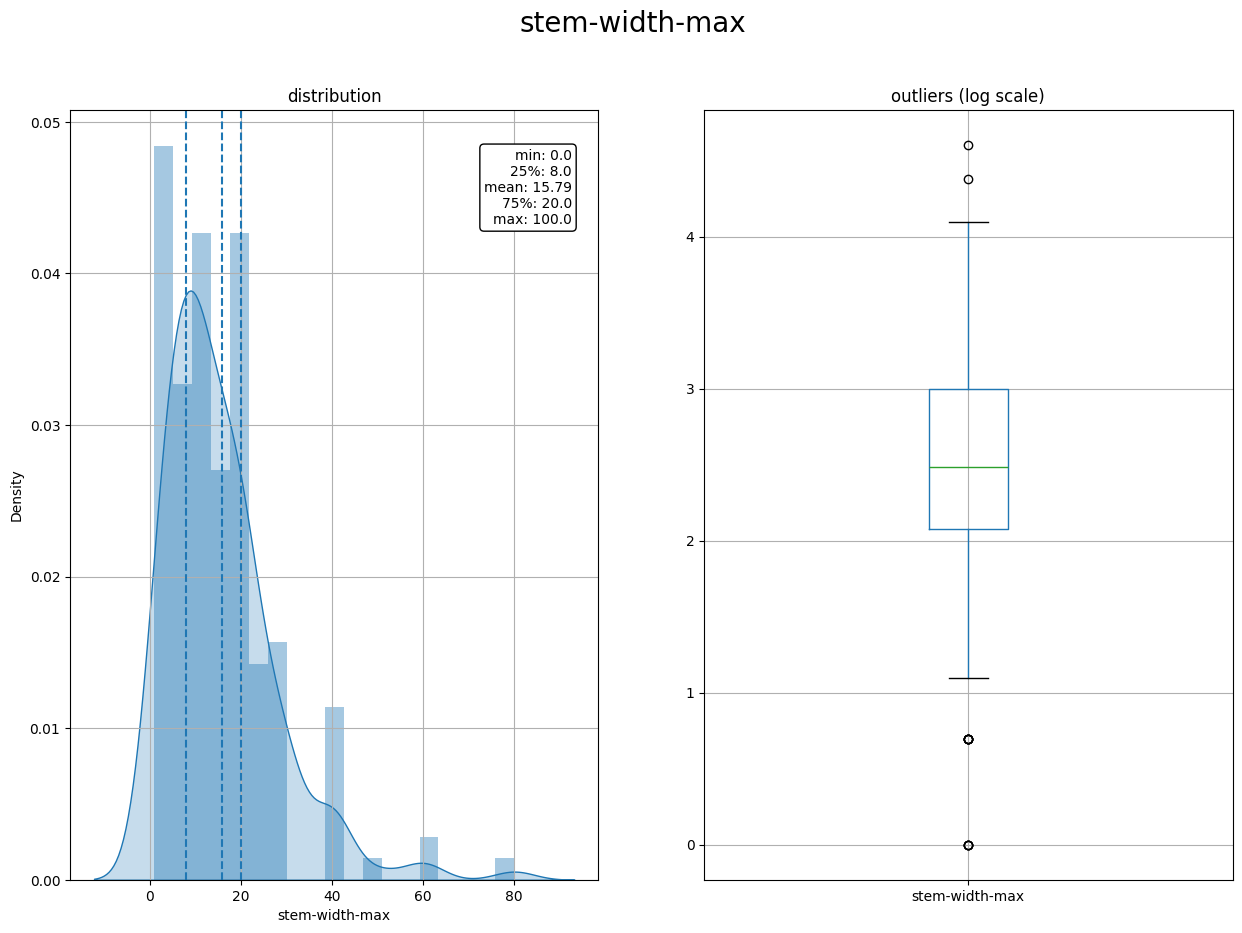

In [ ]:
show_dist('stem-width-max', df)

Выбросы наблюдаются как в нижнем, так и в верхнем диапазоне значений, но их относительно немного

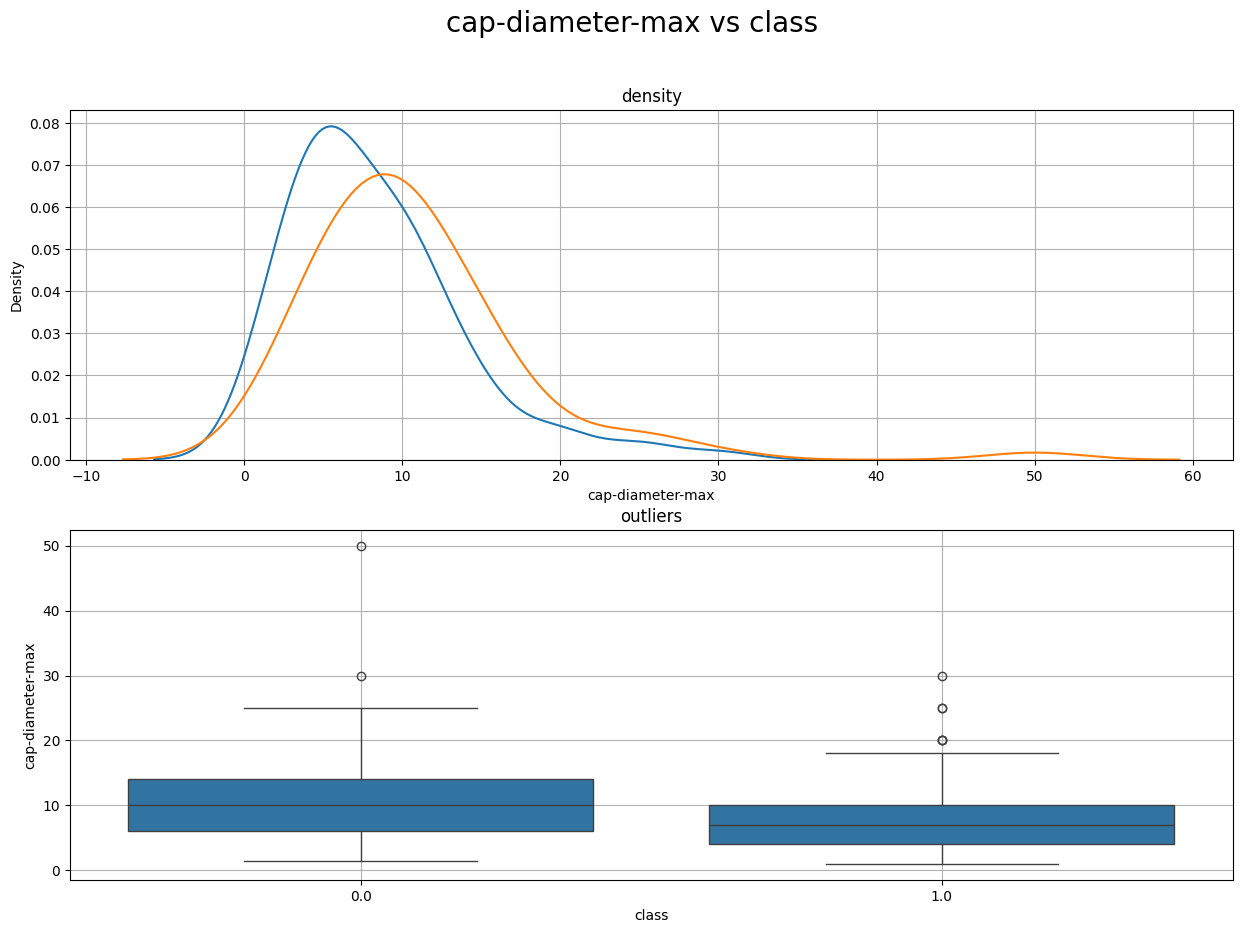

In [11]:
cat, num = "class", "cap-diameter-max"
fig, ax = plt.subplots(nrows=2, ncols=1,  sharex=False, sharey=False, figsize=(15, 10))
fig.suptitle(num + " vs " + cat, fontsize=20)

ax[0].title.set_text('density')
for i in df[cat].unique():
    sns.kdeplot(df[df[cat]==i][num],   label=i, ax=ax[0])
ax[0].grid(True)

ax[1].title.set_text('outliers')
sns.boxplot(x=cat, y=num, data=df, ax=ax[1])

ax[1].grid(True)

plt.show()

In [12]:
dtf_train, dtf_test = model_selection.train_test_split(df, test_size=0.4, random_state=47)

print("X_train shape:", dtf_train.drop("class",axis=1).shape, "| X_test shape:", dtf_test.drop("class",axis=1).shape)
print("y_train mean:", round(np.mean(dtf_train["cap-diameter-max"]),2), "| y_test mean:", round(np.mean(dtf_test["cap-diameter-max"]),2))
print(dtf_train.drop("class",axis=1).shape[1], "features:", dtf_train.drop("class",axis=1).columns.to_list())

X_train shape: (103, 21) | X_test shape: (70, 21)
y_train mean: 9.59 | y_test mean: 9.21
21 features: ['family', 'cap-shape', 'Cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-color', 'stem-color', 'has-ring', 'ring-type', 'habitat', 'season-spring', 'season-summer', 'season-autumn', 'season-winter', 'cap-diameter-min', 'cap-diameter-max', 'stem-height-min', 'stem-height-max', 'stem-width-min', 'stem-width-max']


In [13]:
dtf_train.shape

(103, 22)

In [14]:
train_x = dtf_train.drop("class",axis=1)
train_y = dtf_train['class']

test_x = dtf_test.drop("class",axis=1)
test_y = dtf_test['class']

In [15]:
Y = 'class'

scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(train_x)

train_x_scaled = pd.DataFrame(X, columns=train_x.columns,index=train_x.index )
train_y_scaled = train_y

train_x_scaled.head()

,family,cap-shape,Cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-color,stem-color,has-ring,ring-type,...,season-spring,season-summer,season-autumn,season-winter,cap-diameter-min,cap-diameter-max,stem-height-min,stem-height-max,stem-width-min,stem-width-max
11,0.954545,1.000000,1.000,0.938462,0.0,0.125,0.842105,0.950,1.0,0.923077,...,0.0,1.0,1.0,0.0,0.130435,0.137931,0.266667,0.200000,0.075,0.04
118,0.227273,0.153846,0.475,0.584615,0.0,0.125,0.385965,0.550,0.0,0.153846,...,1.0,1.0,1.0,0.0,0.043478,0.034483,0.200000,0.171429,0.025,0.02
94,0.363636,1.000000,0.700,0.892308,0.0,0.875,0.543860,0.550,0.0,0.153846,...,0.0,1.0,1.0,0.0,0.478261,0.586207,0.333333,0.285714,0.375,0.20
33,0.954545,0.230769,0.325,0.415385,1.0,0.125,0.508772,0.550,0.0,0.153846,...,0.0,1.0,1.0,0.0,0.000000,0.017241,0.266667,0.200000,0.025,0.01
96,0.363636,0.846154,0.950,0.707692,0.0,0.875,0.561404,0.675,0.0,0.153846,...,0.0,0.0,1.0,1.0,0.391304,0.310345,0.200000,0.171429,0.200,0.12


In [16]:
X = scaler.fit_transform(test_x)

test_x_scaled = pd.DataFrame(X, columns = test_x.columns, index = test_x.index)
test_y_scaled = test_y

Text(0.5, 1.0, 'pearson correlation')

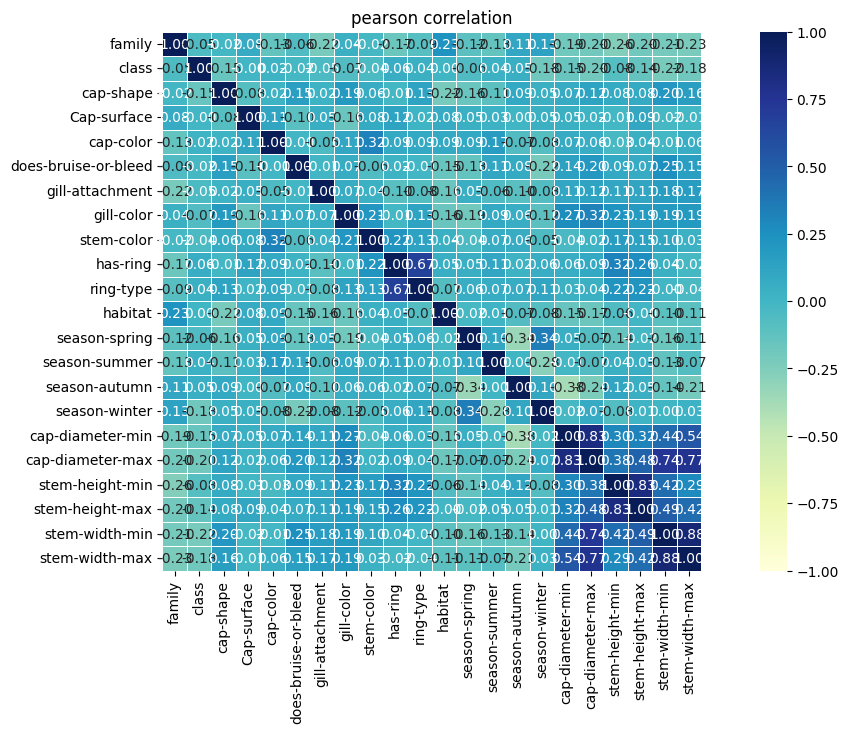

In [17]:
corr_matrix = df.copy()
plt.figure(figsize=(15,7),dpi=100)

for col in corr_matrix.columns:
  if corr_matrix[col].dtype == "O":
      corr_matrix[col] = corr_matrix[col].factorize(sort=True)[0]
corr_matrix = corr_matrix.corr(method="pearson",numeric_only = True)

sns.heatmap(corr_matrix, vmin=-1., vmax=1., annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5, square=True)
plt.title("pearson correlation")

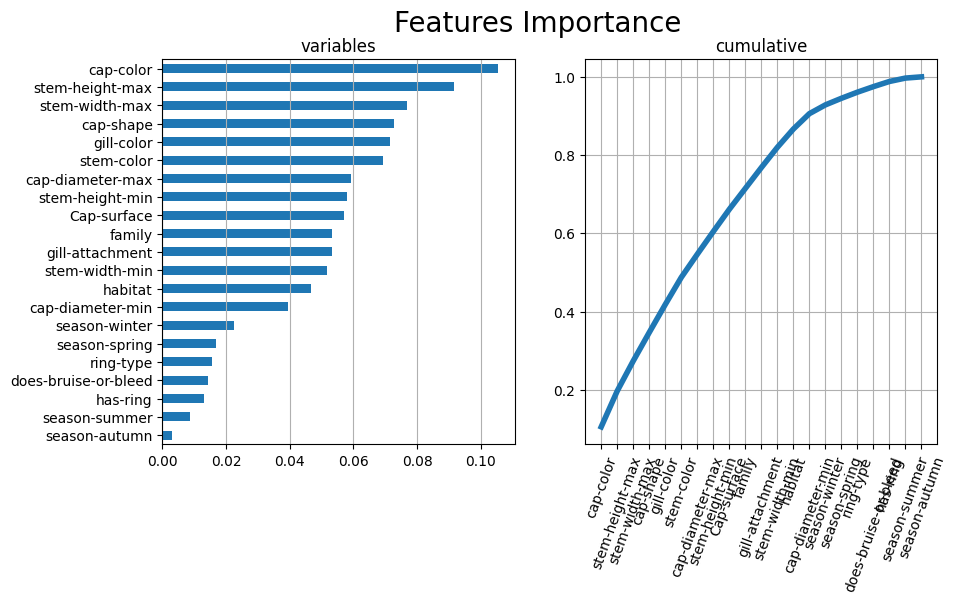

In [18]:
X = train_x_scaled.values
y = train_y_scaled.values
feature_names = train_x_scaled.columns.tolist()

model = ensemble.RandomForestClassifier(n_estimators=100,
                                        criterion="entropy", random_state=0)
model.fit(X,y)
importances = model.feature_importances_

dtf_importances = pd.DataFrame({"IMPORTANCE":importances,
                                "VARIABLE":feature_names}).sort_values("IMPORTANCE",
                                                                       ascending=False)
dtf_importances['cumsum'] = dtf_importances['IMPORTANCE'].cumsum(axis=0)
dtf_importances = dtf_importances.set_index("VARIABLE")

fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False,figsize=(10,5),dpi=100)
fig.suptitle("Features Importance", fontsize=20)
ax[0].title.set_text('variables')
dtf_importances[["IMPORTANCE"]].sort_values(by="IMPORTANCE").plot(
    kind="barh", legend=False, ax=ax[0]).grid(axis="x")
ax[0].set(ylabel="")
ax[1].title.set_text('cumulative')
dtf_importances[["cumsum"]].plot(kind="line", linewidth=4,
                                 legend=False, ax=ax[1])
ax[1].set(xlabel="", xticks=np.arange(len(dtf_importances)),
          xticklabels=dtf_importances.index)
plt.xticks(rotation=70)
plt.grid(axis='both')

plt.show()

In [19]:
X_train = train_x_scaled[['stem-width-max', 'stem-height-max', 'cap-color', 'cap-shape']]
y_train = train_y_scaled

X_test = test_x_scaled[['stem-width-max', 'stem-height-max', 'cap-color', 'cap-shape']]
y_test = test_y_scaled

In [20]:
model = ensemble.GradientBoostingClassifier()

param_dic = {'learning_rate':[0.15,0.1,0.05], #весовой коэффициент для поправок по новым деревьям при добавлении в модель
             'n_estimators':[100,250,500],    #количество деревьев, добавленных в модель
             'max_depth':[2,3,4,5],           #максимальная глубина дерева
             'min_samples_split':[2,4,6],     #задает минимальное количество выборок для разделения
             'min_samples_leaf':[1,3,5],      #минимальное количество выборок для формирования листа
             'max_features':[2,3,4],          #квадратный корень из функций обычно является хорошей отправной точкой
             'subsample':[0.7,0.8,0.9,1]}     #образцы, которые будут использоваться для подгонки индивидуального базового файла

random_search = model_selection.RandomizedSearchCV(
    model,
    param_distributions=param_dic, n_iter=10,
    scoring="accuracy"
).fit(X_train, y_train)

print("Best Model parameters:", random_search.best_params_)
print("Best Model mean accuracy:", random_search.best_score_)
model = random_search.best_estimator_

Best Model parameters: {'subsample': 1, 'n_estimators': 250, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 3, 'max_depth': 4, 'learning_rate': 0.05}
Best Model mean accuracy: 0.7285714285714285


In [21]:
model.fit(X_train, y_train)
predicted_prob = model.predict_proba(X_test)
predicted = model.predict(X_test).astype('int32')

In [22]:
predicted_prob

array([[7.61868994e-02, 9.23813101e-01],
       [3.09304930e-01, 6.90695070e-01],
       [9.00414293e-01, 9.95857075e-02],
       [6.23119962e-01, 3.76880038e-01],
       [1.18350916e-01, 8.81649084e-01],
       [5.61478588e-01, 4.38521412e-01],
       [9.93133906e-01, 6.86609355e-03],
       [3.21260382e-01, 6.78739618e-01],
       [9.81070119e-01, 1.89298813e-02],
       [3.03671041e-01, 6.96328959e-01],
       [2.95233315e-02, 9.70476669e-01],
       [3.88517641e-03, 9.96114824e-01],
       [5.98817153e-01, 4.01182847e-01],
       [5.07012079e-02, 9.49298792e-01],
       [6.17880156e-03, 9.93821198e-01],
       [1.55076275e-01, 8.44923725e-01],
       [5.69994499e-01, 4.30005501e-01],
       [4.49408040e-03, 9.95505920e-01],
       [1.14256241e-01, 8.85743759e-01],
       [2.82404869e-03, 9.97175951e-01],
       [1.19951426e-01, 8.80048574e-01],
       [7.53648070e-02, 9.24635193e-01],
       [1.29868431e-01, 8.70131569e-01],
       [2.62002855e-01, 7.37997145e-01],
       [5.570174

In [23]:
y_test.astype('int32')

,class
139,0
132,0
78,1
31,1
10,1
...,...
74,0
115,1
104,1
54,1


In [24]:
accuracy = metrics.accuracy_score(y_test, predicted)

# auc = metrics.roc_auc_score(y_test, predicted_prob,  multi_class='ovo', average= "weighted")
print("Accuracy (overall correct predictions):",  round(accuracy,2))
# print("Auc:", round(auc,2))

recall = metrics.recall_score(y_test, predicted, average="weighted")
precision = metrics.precision_score(y_test, predicted, average="weighted")
print("Recall (all 1s predicted right):", round(recall,2))
print("Precision (confidence when predicting a 1):", round(precision,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted, target_names=[str(i) for i in np.unique(y_test)]))

Accuracy (overall correct predictions): 0.51
Recall (all 1s predicted right): 0.51
Precision (confidence when predicting a 1): 0.52
Detail:
              precision    recall  f1-score   support

         0.0       0.52      0.34      0.41        35
         1.0       0.51      0.69      0.59        35

    accuracy                           0.51        70
   macro avg       0.52      0.51      0.50        70
weighted avg       0.52      0.51      0.50        70



   - Модель правильно классифицировала 51% объектов из общего числа.
   - Это указывает на то, что модель предсказывает правильно чуть больше половины объектов, что ближе к случайному угадыванию в случае двух классов



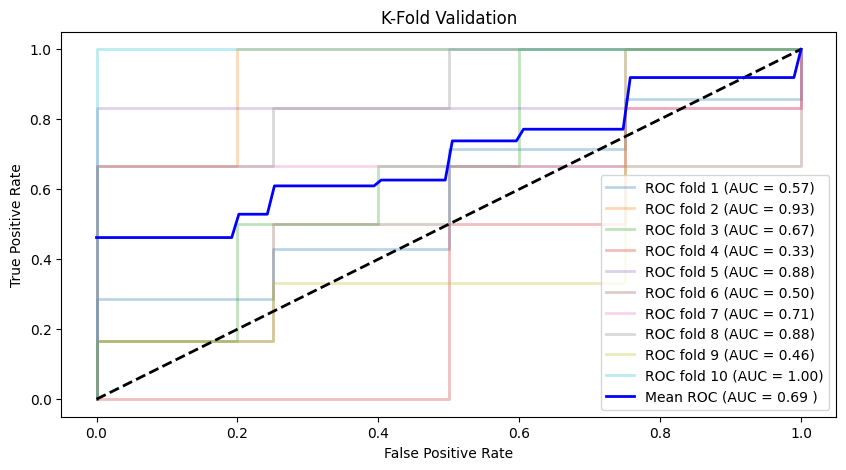

In [25]:
'''
Строим ROC кривые
'''
cv = model_selection.StratifiedKFold(n_splits=10, shuffle=True)
tprs, aucs = [], []
mean_fpr = np.linspace(0,1,100)
fig = plt.figure(figsize=(10,5),dpi=100)
i = 1
for train, test in cv.split(X_train, y_train):
    '''
iloc - позволяет получить определенное значение, принадлежащее к строке и столбцу,
используя указанные значения индекса
X_train - это весь экземпляр с атрибутами,
y_train - это метка каждого экземпляра.
train_selected_test - Разделяет массивы / матрицы на случайные тестовые подмножества.

'''
    X_train_selected = X_train.iloc[train]

    y_train_selected = y_train.iloc[train]
    X_train_selected_test = X_train.iloc[test]
    y_train_selected_test = y_train.iloc[test]

    prediction = model.fit(X_train_selected, y_train_selected).predict_proba(X_train_selected_test)
    fpr, tpr, t = metrics.roc_curve(y_train_selected_test, prediction[:, 1], pos_label=1)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = metrics.auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i = i+1
'''
Получим результат
'''
plt.plot([0,1], [0,1], linestyle='--', lw=2, color='black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = metrics.auc(mean_fpr, mean_tpr)
'''
построим график

'''
plt.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.2f )' % (mean_auc), lw=2, alpha=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('K-Fold Validation')
plt.legend(loc="lower right")

plt.show()

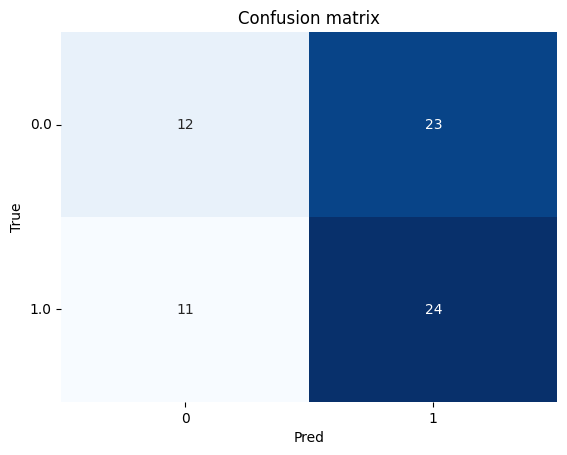

In [26]:
'''
Confusion matrix (Мультиклассовый)
'''

classes = np.unique(y_test)
fig, ax = plt.subplots()
cm = metrics.confusion_matrix(y_test, predicted, labels=classes)
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Pred", ylabel="True", title="Confusion matrix")
ax.set_yticklabels(labels=classes, rotation=0)
'''
построим график

'''

plt.show()

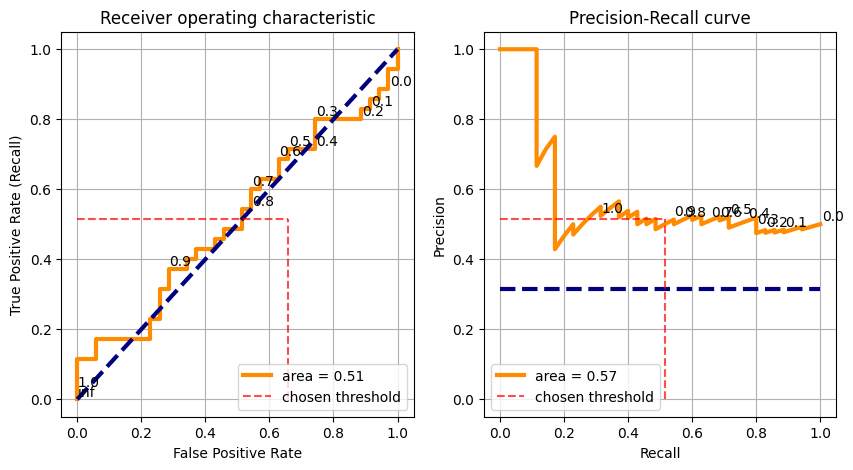

In [27]:
'''
Еще ROC кривые
'''

classes = np.unique(y_test)
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(10,5),dpi=100)
'''

## plot ROC curve
построим кривую ROC

'''
fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted_prob[:, 1], pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
ax[0].plot(fpr, tpr, color='darkorange', lw=3, label='area = %0.2f' % roc_auc)
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].hlines(y=recall, xmin=0, xmax=1-cm[0,0]/(cm[0,0]+cm[0,1]), color='red', linestyle='--', alpha=0.7, label="chosen threshold")
ax[0].vlines(x=1-cm[0,0]/(cm[0,0]+cm[0,1]), ymin=0, ymax=recall, color='red', linestyle='--', alpha=0.7)
ax[0].set(xlabel='False Positive Rate', ylabel="True Positive Rate (Recall)", title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
## annotate ROC thresholds
'''
найдем пороговые значения ROC
'''

thres_in_plot = []
for i,t in enumerate(thresholds):
    t = np.round(t,1)
    if t not in thres_in_plot:
        ax[0].annotate(t, xy=(fpr[i],tpr[i]), xytext=(fpr[i],tpr[i]),
                    textcoords='offset points', ha='left', va='bottom')
        thres_in_plot.append(t)
    else:
        next
## plot P-R curve
'''
плстроим кривую P-R
'''

precisions, recalls, thresholds = metrics.precision_recall_curve(y_test, predicted_prob[:,1], pos_label=1)
roc_auc = metrics.auc(recalls, precisions)
ax[1].plot(recalls, precisions, color='darkorange', lw=3, label='area = %0.2f' % roc_auc)
ax[1].plot([0,1], [(cm[1,0]+cm[1,0])/len(y_test), (cm[1,0]+cm[1,0])/len(y_test)], linestyle='--', color='navy', lw=3)
ax[1].hlines(y=precision, xmin=0, xmax=recall, color='red', linestyle='--', alpha=0.7, label="chosen threshold")
ax[1].vlines(x=recall, ymin=0, ymax=precision, color='red', linestyle='--', alpha=0.7)
ax[1].set(xlabel='Recall', ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="lower left")
ax[1].grid(True)
## annotate P-R thresholds
'''
пороговые значения P-R
'''
thres_in_plot = []
for i,t in enumerate(thresholds):
    t = np.round(t,1)
    if t not in thres_in_plot:
        ax[1].annotate(np.round(t,1), xy=(recalls[i],precisions[i]),
                    xytext=(recalls[i],precisions[i]),
                    textcoords='offset points', ha='left', va='bottom')
        thres_in_plot.append(t)
    else:
        next
plt.show()

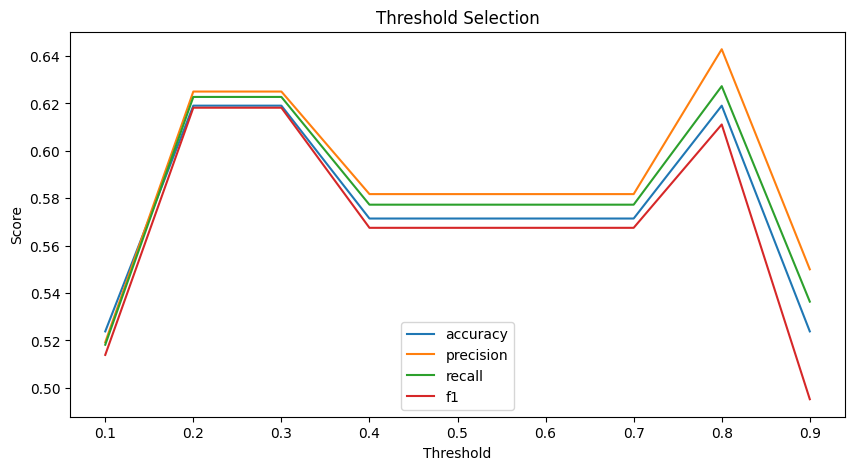

In [28]:
## calculate scores for different thresholds
'''
Определим, какие значения отсечки лучше всего для нашей модели.
Для этого построим график ("значение отсечки", "значение метрики") для каждой метрики accuracy, precision, recall, f1
'''
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10,5),dpi=100)

dic_scores = {'accuracy':[], 'precision':[], 'recall':[], 'f1':[]}
XX_train, XX_test, yy_train, yy_test = model_selection.train_test_split(X_train, y_train, test_size=0.2)
predicted_prob = model.fit(XX_train, yy_train).predict_proba(XX_test)[:,1]
thresholds = []
for threshold in np.arange(0.1, 1, step=0.1):
    predicted = (predicted_prob > threshold)
    thresholds.append(threshold)
    dic_scores["accuracy"].append(metrics.accuracy_score(yy_test, predicted))
    dic_scores["precision"].append(metrics.precision_score(yy_test, predicted, average='macro', zero_division=1))
    dic_scores["recall"].append(metrics.recall_score(yy_test, predicted, average='macro'))
    dic_scores["f1"].append(metrics.f1_score(yy_test, predicted, average='macro'))
'''
Добавим линии
'''
## plot
dtf_scores = pd.DataFrame(dic_scores).set_index(pd.Index(thresholds))
ax.set(xlabel='Threshold', ylabel="Score", title="Threshold Selection")
dtf_scores.plot(ax=ax)
'''
отрисовываем
'''

plt.show()